In [22]:
from loadImgsAndLabels import loadloadImgsAndLabels

from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [23]:
class FullyConnectedNet(nn.Module):
	def __init__(self, layers=[784, 800, 10]):
		super(FullyConnectedNet, self).__init__()
		self.layers = nn.ModuleList([nn.Linear(a, b, dtype=torch.float64) for a, b in zip(layers[:-1], layers[1:])])

	def forward(self, x):
		for layer in self.layers[:-1]:
			x = F.relu(layer(x))
		x = self.layers[-1](x)
		return F.log_softmax(x, dim=1)


def fit(model, device, loader, loss_func, epoch, optimizer=None, log_interval=10, silent=False):
	model.train()
	logs = []

	for batch_idx, (xb, yb) in enumerate(loader):
		xb, yb = xb.to(device), yb.to(device)

		# removing aggregated gradients
		if optimizer: 
			optimizer.zero_grad()
		else:
			model.zero_grad()		# <- this line

		# backporpagation
		pred = model(xb)
		loss = loss_func(pred, yb)
		loss.backward()

		# applying gradients 
		if optimizer: 
			optimizer.step()
		else:
			for param in model.parameters():		# <- this line
				param.data -= param.grad * 0.01		# <- this line

		# telemetry
		if batch_idx & log_interval == 0:
			logs.append(loss.item())
			if not silent:
				print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
					epoch, batch_idx * len(xb), len(loader.dataset),
					100. * batch_idx / len(loader), loss.item()
				))
	return logs
				

def test(model, device, loader, loss_func, silent=False):
	model.eval()
	test_loss = 0
	correct_pred = 0
	with torch.no_grad():
		for xb, yb in loader:
			xb, yb = xb.to(device), yb.to(device)
			pred = model(xb)
			test_loss += loss_func(pred, yb, reduction='sum').item()
			pred = pred.argmax(dim=1, keepdim=True)
			correct_pred += pred.eq(yb.view_as(pred)).sum().item()
	
	test_loss /= len(loader.dataset)
	if not silent:
		print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
			test_loss, correct_pred, len(loader.dataset),
			100. * correct_pred / len(loader.dataset)
		))
	return correct_pred / len(loader.dataset)

In [24]:
batch_size = 128
test_batch_size = 512
epochs = 5
lr = 1e-2
log_interval = 10
torch.manual_seed(1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f'Using CUDA: {use_cuda}')
print(f'Using device: {torch.cuda.get_device_name(device)}')

Using CUDA: True
Using device: NVIDIA GeForce GTX 1050


In [25]:
x_train, y_train = loadloadImgsAndLabels(
	'../datasets/train-images.idx3-ubyte',
	'../datasets/train-labels.idx1-ubyte'
)

x_train, x_val = np.split(x_train, [50000])
y_train, y_val = np.split(y_train, [50000])

x_test, y_test = loadloadImgsAndLabels(
	'../datasets/t10k-images.idx3-ubyte',
	'../datasets/t10k-labels.idx1-ubyte'
)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

x_train, y_train, x_val, y_val, x_test, y_test = map(
	torch.tensor,
	(x_train, y_train, x_val, y_val, x_test, y_test)
)

train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)
test_ds = TensorDataset(x_test, y_test)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=test_batch_size)
test_dl = DataLoader(test_ds, batch_size=test_batch_size)

(50000, 784) (50000,)
(10000, 784) (10000,)
(10000, 784) (10000,)


torch.Size([50000, 784])

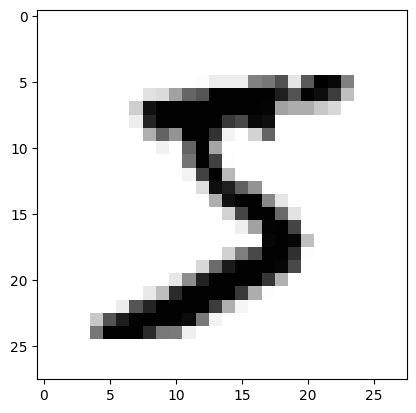

In [26]:
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')
x_train.shape

In [27]:
model = FullyConnectedNet().to(device)
model.requires_grad_()
loss_func = F.nll_loss # F.cross_entropy

train_history = []
acc_history = []

for epoch in range(1, epochs + 1):
	train_history.extend(
		fit(model, device, train_dl, loss_func, epoch)
	)
	acc_history.append(
		test(model, device, test_dl, loss_func, silent=True)
	)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.367234
Train Epoch: 1 [128/50000 (0%)]	Loss: 2.313480
Train Epoch: 1 [512/50000 (1%)]	Loss: 2.275128
Train Epoch: 1 [640/50000 (1%)]	Loss: 2.266869
Train Epoch: 1 [2048/50000 (4%)]	Loss: 2.241155
Train Epoch: 1 [2176/50000 (4%)]	Loss: 2.216645
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.216447
Train Epoch: 1 [2688/50000 (5%)]	Loss: 2.218530
Train Epoch: 1 [4096/50000 (8%)]	Loss: 2.182607
Train Epoch: 1 [4224/50000 (8%)]	Loss: 2.140512
Train Epoch: 1 [4608/50000 (9%)]	Loss: 2.122462
Train Epoch: 1 [4736/50000 (9%)]	Loss: 2.154115
Train Epoch: 1 [6144/50000 (12%)]	Loss: 2.093301
Train Epoch: 1 [6272/50000 (13%)]	Loss: 2.089718
Train Epoch: 1 [6656/50000 (13%)]	Loss: 2.085319
Train Epoch: 1 [6784/50000 (14%)]	Loss: 2.083969
Train Epoch: 1 [8192/50000 (16%)]	Loss: 2.000056
Train Epoch: 1 [8320/50000 (17%)]	Loss: 2.002802
Train Epoch: 1 [8704/50000 (17%)]	Loss: 2.066634
Train Epoch: 1 [8832/50000 (18%)]	Loss: 2.041318
Train Epoch: 1 [10240/50000 (20%)]	Los

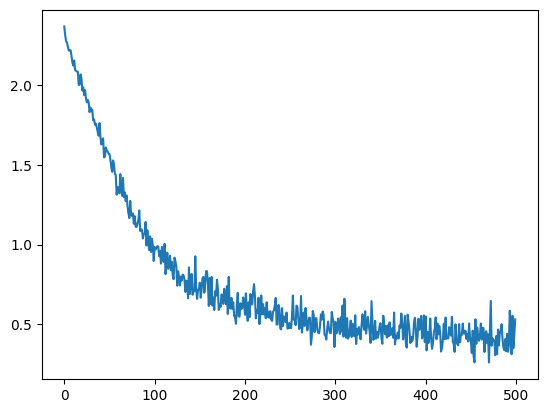

In [28]:
plt.plot(train_history)